# Logistic Regression

Sections:
- 0: Setup
- 1: Introduction to Logistic Regression (toy example)
- 2: Sigmoid Function and Classification Intuition
- 3: Logistic Regression on a Real Dataset
- 4: Evaluation Metrics and Threshold Effects
- 5: L2 Regularization
- 6: Conclusion and Next Steps

## Section 0 – Setup

In this section we will:
- Import required libraries
- Set a random seed for reproducibility
- A short outline for students to follow the flow.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler

## Section 1 – Introduction to Logistic Regression (toy example)

Goal:
- A very simple feel of what logistic regression does before we dive into math.

We will create a tiny toy dataset:
- Feature: `hours_studied`
- Target: `pass_exam` (0 or 1)

Then we will:
- Fit a logistic regression model in sklearn
- Predict pass or fail for a few sample students
- Plot the points and the model prediction curve.

Outcome:
- Linear regression predicts a continuous number
- Logistic regression predicts a probability between 0 and 1.


In [5]:
# Create a simple toy dataset
hours_studied = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(-1, 1)
pass_exam = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])

toy_df = pd.DataFrame({
    "hours_studied": hours_studied.flatten(),
    "pass_exam": pass_exam
})

toy_df

,hours_studied,pass_exam
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1


In [6]:
toy_model = LogisticRegression()

toy_model.fit(hours_studied, pass_exam)

LogisticRegression()

In [7]:
intercept = toy_model.intercept_
coef  = toy_model.coef_
print("intercept:", intercept)
print("Co-Efficient:", coef)

intercept: [-5.29559243]
Co-Efficient: [[1.17808562]]


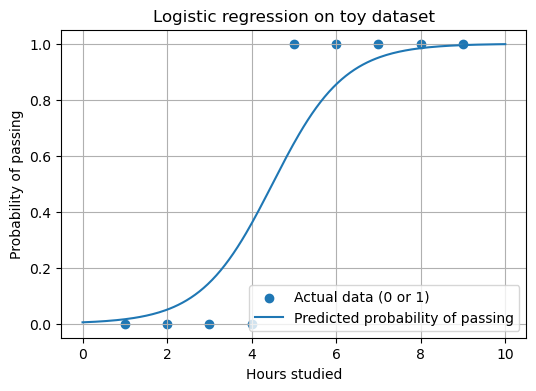

In [8]:
hours_grid = np.linspace(0, 10, 200).reshape(-1, 1)
pass_prob = toy_model.predict_proba(hours_grid)[:, 1]

# Plot data points and probability curve
plt.figure(figsize=(6, 4))
plt.scatter(hours_studied, pass_exam, label="Actual data (0 or 1)")
plt.plot(hours_grid, pass_prob, label="Predicted probability of passing")
plt.xlabel("Hours studied")
plt.ylabel("Probability of passing")
plt.title("Logistic regression on toy dataset")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
example_hours = np.array([[2],[4],[6], [8]])
exmaple_probs = toy_model.predict_proba(example_hours)[:, 1]
exmaple_pred = toy_model.predict(example_hours)

result_df = pd.DataFrame({
    "Hours_Studied": example_hours.flatten(),
    "Predicted_probability_pass": np.round(exmaple_probs, 4),
    "PRedicted_class": exmaple_pred
})

In [10]:
result_df

,Hours_Studied,Predicted_probability_pass,PRedicted_class
0,2,0.0502,0
1,4,0.3582,0
2,6,0.8548,1
3,8,0.9842,1


## Section 2 – Sigmoid Function and Classification Intuition

Here we:
- Define the sigmoid function in code
- See how it maps any real number to a probability between 0 and 1
- Check some example values
- Visualize the sigmoid curve
- Play with a simple decision threshold.

In [12]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

z_values = np.array([-8, -5, -2, -1, 0,1,2,5, 9], dtype=float)
sig_values = sigmoid(z_values)

sig_df = pd.DataFrame({
    "z": z_values,
    "sigmoid(z)": np.round(sig_values, 4)
})


sig_df

,z,sigmoid(z)
0,-8.0,0.0003
1,-5.0,0.0067
2,-2.0,0.1192
3,-1.0,0.2689
4,0.0,0.5000
5,1.0,0.7311
6,2.0,0.8808
7,5.0,0.9933
8,9.0,0.9999


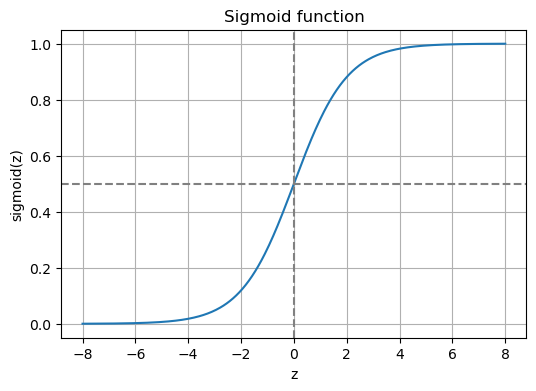

In [13]:
# Plot the sigmoid curve
z_grid = np.linspace(-8, 8, 400)
sig_grid = sigmoid(z_grid)

plt.figure(figsize=(6, 4))
plt.plot(z_grid, sig_grid)
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid function")
plt.grid(True)
plt.axhline(0.5, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

In [14]:
# Simple threshold demonstration
probabilities = np.array([0.1, 0.3, 0.49, 0.5, 0.7, 0.9])
threshold = 0.5
pred_class = (probabilities >= threshold).astype(int)

thresh_df = pd.DataFrame({
    "probability": probabilities,
    "class_at_threshold_0.5": pred_class
})
thresh_df

,probability,class_at_threshold_0.5
0,0.10,0
1,0.30,0
2,0.49,0
3,0.50,1
4,0.70,1
5,0.90,1


## Section 3 – Logistic Regression on a Real Dataset

Now we move to a real dataset. To keep it simple and local inside the notebook, we will use the `breast_cancer` dataset from `sklearn`.

Goal:
- Load data
- Do a quick EDA
- Train logistic regression
- Evaluate using basic metrics
- Inspect confusion matrix and classification report.


In [32]:
data = load_breast_cancer()
X_full = data.data
y_full = data.target

In [36]:
print("Feature matrix shape:", X_full.shape)
print("Target shape:", y_full.shape)
print("Classes:", data.target_names)

Feature matrix shape: (569, 30)
Target shape: (569,)
Classes: ['malignant' 'benign']


In [40]:
feature_names= data.feature_names
df = pd.DataFrame(X_full, columns=feature_names)
df["target"]= y_full
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [46]:
df.describe().T.head(15)

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.37000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.84000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.24000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.10000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.09587,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.09263,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.06154,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.03350,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.17920,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.06154,0.066120,0.09744


In [48]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled)
y_test_proba= clf.predict_proba(X_test_scaled)[:,1]

In [54]:
print("test accuracy", accuracy_score(y_test, y_test_pred))

test accuracy 0.9824561403508771


In [58]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[41  1]
 [ 1 71]]


In [60]:
print("Classification Report\n", classification_report(y_test, y_test_pred))

Classification Report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



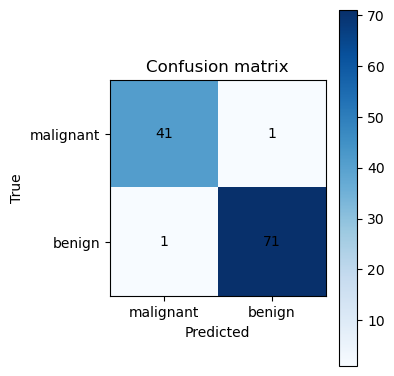

In [62]:
# Visual confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix")
plt.colorbar()
tick_labels = data.target_names
plt.xticks([0, 1], tick_labels)
plt.yticks([0, 1], tick_labels)
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers to each cell
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

**Notes:**

- Even with a simple model like logistic regression, performance can be quite strong when the relationship is roughly linear in the feature space.
- Each cell in the confusion matrix means: true positive, true negative, false positive, false negative.


## Section 4 – Evaluation Metrics and Threshold Effects

We now:
- Compute accuracy, precision, recall, F1
- Experiment with different classification thresholds on the predicted probabilities
- See how precision and recall trade off when we move the threshold.


In [68]:
# Basic metrics at default threshold 0.5
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)

Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1 score: 0.9861111111111112


In [70]:
# Try different thresholds and see how precision and recall change
thresholds = np.linspace(0.1, 0.9, 9)#0.1,0.2,0.3,0.4...
rows = []

for thr in thresholds:
    y_thr_pred = (y_test_proba >= thr).astype(int)
    acc_thr = accuracy_score(y_test, y_thr_pred)
    prec_thr = precision_score(y_test, y_thr_pred)
    rec_thr = recall_score(y_test, y_thr_pred)
    f1_thr = f1_score(y_test, y_thr_pred)
    rows.append([thr, acc_thr, prec_thr, rec_thr, f1_thr])

thr_df = pd.DataFrame(rows, columns=["threshold", "accuracy", "precision", "recall", "f1"])
thr_df

,threshold,accuracy,precision,recall,f1
0,0.1,0.956140,0.935065,1.000000,0.966443
1,0.2,0.982456,0.972973,1.000000,0.986301
2,0.3,0.982456,0.972973,1.000000,0.986301
3,0.4,0.982456,0.986111,0.986111,0.986111
4,0.5,0.982456,0.986111,0.986111,0.986111
5,0.6,0.956140,0.985507,0.944444,0.964539
6,0.7,0.947368,0.985294,0.930556,0.957143
7,0.8,0.938596,0.985075,0.916667,0.949640
8,0.9,0.894737,0.983871,0.847222,0.910448


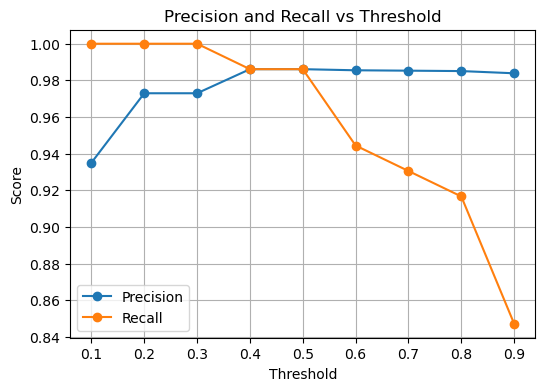

In [72]:
# Plot precision and recall vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thr_df["threshold"], thr_df["precision"], marker="o", label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"], marker="o", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

**Notes:**

- If you want fewer false negatives (for example, missing a serious disease), should you increase or decrease the threshold.
- Explain that decreasing the threshold usually increases recall but may reduce precision.


## Section 5 – L2 Regularization

Regularization helps control model complexity by shrinking coefficients.

In sklearn's `LogisticRegression`:
- `penalty="l2"` is the default
- `C` controls strength of regularization. Smaller `C` means stronger regularization.

Here we:
- Train two models with different `C` values
- Compare their coefficients and performance.


In [76]:
clf_weak_reg = LogisticRegression(max_iter=100, C=1000) # weak regularization
clf_strong_reg = LogisticRegression(max_iter=100, C=0.01) # strong regularization

clf_weak_reg.fit(X_train_scaled, y_train)
clf_strong_reg.fit(X_train_scaled, y_train)

y_weak_pred = clf_weak_reg.predict(X_test_scaled)
y_strong_pred = clf_strong_reg.predict(X_test_scaled)


print("Weak reg (C=1000) test accuracy: ", accuracy_score(y_test, y_weak_pred))
print("Strong reg (C=0.01) test accuracy: ", accuracy_score(y_test, y_strong_pred))

Weak reg (C=1000) test accuracy:  0.9298245614035088
Strong reg (C=0.01) test accuracy:  0.9473684210526315


In [80]:
# Compare coefficient magnitudes
coef_weak = clf_weak_reg.coef_[0]
coef_strong = clf_strong_reg.coef_[0]
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef_weak_C_1000":coef_weak,
    "coef_strong_C_0.01":coef_strong
})

coef_df.head(15)


,feature,coef_weak_C_1000,coef_strong_C_0.01
0,mean radius,6.963009,-0.212316
1,mean texture,-7.053054,-0.180606
2,mean perimeter,3.203030,-0.209968
3,mean area,-3.070364,-0.196291
4,mean smoothness,-5.270189,-0.102438
5,mean compactness,30.138942,-0.098428
6,mean concavity,-9.979290,-0.149764
7,mean concave points,-6.621746,-0.206900
8,mean symmetry,0.293822,-0.080873
9,mean fractal dimension,-7.435451,0.079728


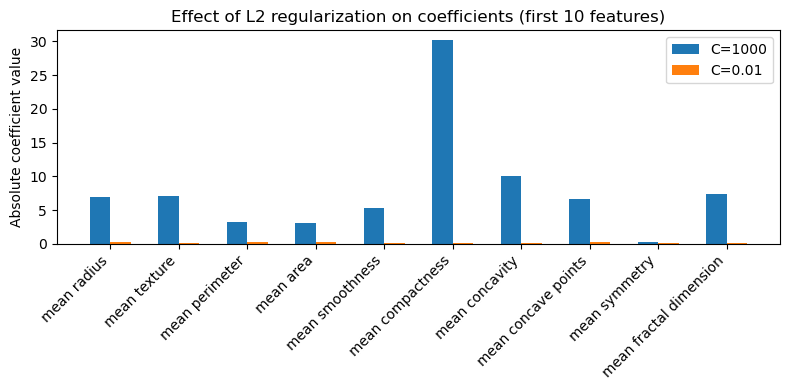

In [86]:
# Plot absolute values for the first 10 coefficients
n_plot = 10
indices = np.arange(n_plot)

plt.figure(figsize=(8, 4))
plt.bar(indices - 0.15, np.abs(coef_weak[:n_plot]), width=0.3, label="C=1000")
plt.bar(indices + 0.15, np.abs(coef_strong[:n_plot]), width=0.3, label="C=0.01")
plt.xticks(indices, feature_names[:n_plot], rotation=45, ha="right")
plt.ylabel("Absolute coefficient value")
plt.title("Effect of L2 regularization on coefficients (first 10 features)")
plt.legend()
plt.tight_layout()
plt.show()

**Notes:**

- With stronger regularization (smaller C), many coefficients become smaller in magnitude.
- This often leads to better generalization by avoiding extremely large weights that overfit noise.


## Section 6 – Conclusion and Next Steps

In this module we covered:

- Why logistic regression is used for classification instead of linear regression
- How the sigmoid function converts scores to probabilities
- The idea of log odds and a linear decision boundary
- Training logistic regression with a suitable cost function (binary cross entropy)
- Implementing logistic regression on a real dataset with sklearn
- Evaluating models using accuracy, precision, recall, F1, and confusion matrix
- Improving generalization with L2 regularization by shrinking coefficients.

**What you should be able to do now:**

- Explain logistic regression
- Implement logistic regression in sklearn on a tabular dataset
- Interpret confusion matrices and basic classification metrics
- Experiment with thresholds and understand the trade off between precision and recall
- Understand the role of L2 regularization and the effect of the C parameter.

**Next steps:**

- Move to other classification models like decision trees and random forests
- Explore multi class classification with softmax based logistic regression
